In [2]:
import itertools
from pymatgen.core.periodic_table import get_el_sp, Element


def get_distance_matrix(lavec, xf):
    
    xshift = np.zeros((3, 27))
    
    shifts = [-1, 0, 1]
    
    m = 1
    for i, j, k in itertools.product(shifts, shifts, shifts):
        if i == 0 and j == 0 and k == 0:
            continue
        
        xshift[0, m] = i
        xshift[1, m] = j
        xshift[2, m] = k
        
        m += 1
    
    distance_matrix = []
    
    for isite in range(len(xf)):
        
        distance_info_isite = []
        distlist = []
        
        for jsite in range(len(xf)):
            
            distance_min = 1.0e+12
            im_min = 0
            
            for im in range(27):
                
                xf_diff = xf[jsite,:] + xshift[:, im] - xf[isite,:]
                xc_diff = np.dot(xf_diff, lavec)
                distance = np.sqrt(np.dot(xc_diff, xc_diff))
                
                if distance < distance_min:
                    im_min = im
                    distance_min = distance
            
            xf_min = xf[jsite,:] + xshift[:,im_min]
            xc_min = np.dot(xf_min, lavec)
#            print(distance_min, im_min, xc_min)
            
            distance_info_isite.append([jsite, distance_min, im_min, xc_min])
            distlist.append(distance_min)
        
        distance_info_isite = np.array(distance_info_isite)
        index_sorted = np.argsort(distance_info_isite[:,1])
#        print(distance_info_isite[index_sorted])

        distance_matrix.append(distance_info_isite[index_sorted])        
        #distance_matrix.append(distance_info_isite)
        
    return distance_matrix


def load_phonon_results(file_in):

        tol_zero = 1.0e-3

        f = open(file_in, 'r')

        # skip 10 lines
        for i in range(10):
            f.readline()

        nmode = int(f.readline().split(':')[1])
        nq = int(f.readline().split(':')[1])
        nkd = int(f.readline().split(':')[1])
        mass = [float(t) for t in f.readline().split(':')[1].split()]
        # skip 3 lines
        for i in range(3):
            f.readline()

        omega2 = np.zeros((nq, nmode))

        evec = np.zeros((nq, nmode, nmode), dtype=np.complex128)
        xq = np.zeros((nq, 3))

        for iq in range(nq):
            xq_tmp = [float(a) for a in (f.readline().split(':')[1]).split()]
            xq[iq, :] = xq_tmp[:]
            for imode in range(nmode):
                omega2[iq, imode] = float(f.readline().split(':')[1])
                for jmode in range(nmode):
                    line = f.readline().split()
                    evec[iq, imode, jmode] = complex(
                        float(line[0]), float(line[1]))
                f.readline()
            f.readline()

        f.close()
        
        return mass, xq, nmode, omega2, evec
    

def load_initial_structure(file_in):

        with open(file_in, 'r') as file_pos:
            file_pos.readline()
            a = float(file_pos.readline().rstrip())
            lavec = np.zeros((3, 3))
            for i in range(3):
                arr = file_pos.readline().rstrip().split()
                if len(arr) != 3:
                    raise RuntimeError("Could not read POSCAR properly")
                for j in range(3):
                    lavec[i, j] = a * float(arr[j])

            lavec = lavec.transpose()
            invlavec = np.linalg.inv(lavec)
            elements = file_pos.readline().rstrip().split()

            if elements[0].isdigit():
                nat_elem = [int(tmp) for tmp in elements]
                elements = []
            else:
                nat_elem = [int(tmp) for tmp in file_pos.readline().rstrip().split()]

            nat = np.sum(nat_elem)
            basis = file_pos.readline().strip()
            x = np.zeros((nat, 3))

            for i in range(nat):
                arr = file_pos.readline().rstrip().split()
                for j in range(3):
                    x[i][j] = float(arr[j])

            if basis == "Direct" or basis == "direct" or basis == "D" or basis == "d":
                xf = x
            else:
                xf = np.dot(x, invlavec)

            kd = []
            for i in range(len(nat_elem)):
                kd.extend([i] * nat_elem[i])

        return lavec, invlavec, elements, np.array(kd, dtype=int), nat_elem, np.sum(nat_elem), xf
    

def get_distance_table(structure):
    nsites = structure.num_sites

    distance_table = []
    
    for isite in range(nsites):
        distlist = []
        for jsite in range(nsites):
            if jsite == isite:
                continue
                
            distlist.append([jsite, structure.get_distance(i=isite,j=jsite)])
        
        index_sorted = np.argsort(np.array(distlist)[:,1])        
        distance_table.append(np.array(distlist)[index_sorted])
    
    return distance_table


def find_structure_unit(structure, 
                        distance_table, 
                        atomic_kinds=['C', 'N', 'H'], 
                        num_entries=[1, 1, 6]):

    num_kinds = len(atomic_kinds)
    
    if num_kinds < 2:
        raise RuntimeError("length of atomic_kinds must be >= 2.")
        
    if len(num_entries) != len(atomic_kinds):
        raise RuntimeError("length of atomic_kinds and num_entries must be identical.")
        
    elem_nums = structure.atomic_numbers
    structure_units = []
    
    for isite in range(structure.num_sites):
                
        if str(get_el_sp(elem_nums[isite])) == atomic_kinds[0]:
            structure_unit = []
            structure_unit.append(isite)
            
            for ikind in range(1, num_kinds):
                nsearch = num_entries[ikind]
                nfound = 0
                
                for jsite in distance_table[isite][:,0]:
                    if str(get_el_sp(elem_nums[int(jsite)])) == atomic_kinds[ikind]:
                        structure_unit.append(int(jsite))
                        nfound += 1
                        
                        if nfound == nsearch:
                            break
                            
            structure_units.append(structure_unit)
        
    return structure_units


def build_structure_network(structure):
    
    distance_table = get_distance_table(structure)
    molecular_units = find_structure_unit(structure, distance_table, 
                                         atomic_kinds=['C', 'N', 'H'], 
                                         num_entries=[1, 1, 6])
    
    octahedral_units = find_structure_unit(structure, distance_table, 
                                           atomic_kinds=['Pb', 'I'], 
                                           num_entries=[1, 6])
    
    return molecular_units, octahedral_units


def get_center_of_mass(mass, kd, structure_cluster, distance_matrix):
    
    sum_mass = 0.0
    sum_numerator = np.zeros(3)
    
    distance_matrix_sub = distance_matrix[structure_cluster[0]]
    
    for atom in structure_cluster:
        sum_mass += mass[kd[atom]]
        for elem in distance_matrix_sub:
            if atom == elem[0]:
                sum_numerator += mass[kd[atom]] * elem[3]
    
    return sum_numerator/sum_mass


def get_displacement(mass, kd, evec_mode, magnitude=1.0):
    
    nat = len(evec_mode) // 3
    evec_tmp = np.reshape(evec_mode, (nat, 3))

    disp = np.zeros((nat, 3))
    
    for iat in range(nat):
        disp[iat,:] = np.real(evec_tmp[iat,:]) * magnitude / np.sqrt(mass[kd[iat]])
    
    return disp


def get_translation_displacement(mass, kd, structure_cluster, disp, weights):
    """
     Compute the displacement associated with the ridig translation of a cluster
     defined by structure_cluster.
    
     disp: displacement in Cartesian coordinate
     weights: weight of each atom (<=1). When different clusters share the same atom
              the weight should be divided appropriately.
    """
    
    natom, _ = np.shape(disp)
    disp_translation = np.zeros((natom, 3))
    
    sum_mass = 0.0
    sum_numerator = np.zeros(3)
    
    distance_matrix_sub = distance_matrix[structure_cluster[0]]
    
    #print(structure_cluster)
    
    for atom in structure_cluster:
        sum_mass += mass[kd[atom]]
        sum_numerator += mass[kd[atom]] * disp[atom]
    
    disp_cm = sum_numerator/sum_mass

    for i, atom in enumerate(structure_cluster):
        for elem in distance_matrix_sub:
            if atom == elem[0]:
                disp_translation[atom,:] = disp_cm[:] * weights[i]
                
    return disp_cm, disp_translation


def get_inertial_along_axis(mass, kd, structure_cluster, distance_matrix, axis):
    """
     Compute the inertial of the structure cluster along an axis
     which penetrates the center of the mass of the cluster.
    """
    
    inertial = 0.0

    position_cm = get_center_of_mass(mass, kd, structure_cluster, distance_matrix)
    distance_matrix_sub = distance_matrix[structure_cluster[0]]
    
    for atom in structure_cluster:
        for elem in distance_matrix_sub:
            if atom == elem[0]:
                position_shifted = elem[3] - position_cm
                inertial += mass[kd[atom]] \
                    * (np.dot(position_shifted, position_shifted) - np.dot(position_shifted, axis)**2)
    
    return inertial


def get_angular_momentum(mass, kd, structure_cluster, disp, distance_matrix):
    """
     Compute the angular momentum vector assuming that Delta_t is 1.
     Note that the value of Delta_t is arbitrary and does not change the final result.
    """
    
    position_cm = get_center_of_mass(mass, kd, structure_cluster, distance_matrix)
    distance_matrix_sub = distance_matrix[structure_cluster[0]]
    
    angular_momentum = np.zeros(3)
    
    for atom in structure_cluster:
        for elem in distance_matrix_sub:
            if atom == elem[0]:
                position_shifted = elem[3] - position_cm
                angular_momentum += mass[kd[atom]] * np.cross(position_shifted, disp[atom])
                
    return angular_momentum
                


def get_rotation_displacement(mass, kd, 
                              structure_cluster, 
                              disp, weights, 
                              distance_matrix, 
                              axes):
    
    natom, _ = np.shape(disp)
    disp_rot1 = np.zeros((natom, 3))
    disp_rot2 = np.zeros((natom, 3))
    disp_rot3 = np.zeros((natom, 3))
    
    axis1 = axes[0]
    axis2 = axes[1]
    axis3 = axes[2]
    
    inertial1 = get_inertial_along_axis(mass, kd, structure_cluster, distance_matrix, axis1)
    inertial2 = get_inertial_along_axis(mass, kd, structure_cluster, distance_matrix, axis2)
    inertial3 = get_inertial_along_axis(mass, kd, structure_cluster, distance_matrix, axis3)

    angular_momentum = get_angular_momentum(mass, kd, structure_cluster, disp, distance_matrix)
    position_cm = get_center_of_mass(mass, kd, structure_cluster, distance_matrix)
    distance_matrix_sub = distance_matrix[structure_cluster[0]]

    for i, atom in enumerate(structure_cluster):
        for elem in distance_matrix_sub:
            if atom == elem[0]:
                position_shifted = elem[3] - position_cm
                disp_rot1[atom, :] = np.dot(axis1, angular_momentum) \
                                    * np.cross(axis1, position_shifted) / inertial1 * weights[i]
                disp_rot2[atom, :] = np.dot(axis2, angular_momentum) \
                                    * np.cross(axis2, position_shifted) / inertial2 * weights[i]
                disp_rot3[atom, :] = np.dot(axis3, angular_momentum) \
                                    * np.cross(axis3, position_shifted) / inertial3 * weights[i]
    
    return disp_rot1, disp_rot2, disp_rot3


def find_axis(structure_cluster, distance_matrix, cluster_type='molecule'):

    if cluster_type == 'octahedra':
        axis1 = np.array([1.0, 0.0, 0.0])
        axis2 = np.array([0.0, 1.0, 0.0])
        axis3 = np.array([0.0, 0.0, 1.0])
        
        return axis1, axis2, axis3
    
    if cluster_type == 'molecule':
        
        # Here we assume that the first entry of the cluster is "C" 
        # and the second entry of the cluster is "N".
        
        distance_matrix_sub = distance_matrix[structure_cluster[0]]
        
        index_C = structure_cluster[0]
        index_N = structure_cluster[1]
        
        pos_C = np.zeros(3)
        pos_N = np.zeros(3)
        
        for elem in distance_matrix_sub:
            if elem[0] == index_C:
                pos_C = elem[3]
            if elem[0] == index_N:
                pos_N = elem[3]
        
        # The first axis is parallel to the C-N bond
        axis1 = pos_N - pos_C
        axis1 = axis1 / np.sqrt(np.dot(axis1, axis1))
        
        # The second and third axes can be any vectors 
        # that are orthogonal with each other (and with axis1)
        axis2 = np.array([0, 1., 0])
        axis2 = axis2 - np.dot(axis1, axis2)*axis1
        axis2 = axis2 / np.sqrt(np.dot(axis2, axis2))
        
        axis3 = np.array([0, 0, 1.])
        axis3 = axis3 - np.dot(axis1, axis3)*axis1 - np.dot(axis2, axis3)*axis2
        axis3 = axis3 / np.sqrt(np.dot(axis3, axis3))
        
        return axis1, axis2, axis3
    

def get_internal_vibration(structure_cluster, disp, weights):
    """
     Compute the displacement categorized as the internal vibration.
    
     disp: displacement in Cartesian coordinate without translation and rotation components
     weights: weight of each atom (<=1). When different clusters share the same atom
              the weight should be divided appropriately.
    """
    
    natom, _ = np.shape(disp)
    disp_internal = np.zeros((natom, 3))
    
    distance_matrix_sub = distance_matrix[structure_cluster[0]]
        
    for i, atom in enumerate(structure_cluster):
        disp_internal[atom] = disp[atom,:] * weights[i]
    
    return disp_internal


def compute_fraction(mass, kd,
                     d_tran_MA, d_spin_MA, d_libr_MA, d_vib_MA, 
                     d_tran_PbI6, d_spin_PbI6, d_libr_PbI6, d_vib_PbI6):
    """
     Compute the fraction of each vibrational type following 
     Eq. (6) of J.Phys.Chem. C 2015, 119, 25703−25718 
    """
    
    denom = 0.0
    nat, _ = np.shape(d_tran_MA)
    
    fractions = np.zeros(8)
        
    for iat in range(nat):
        fractions[0] += mass[kd[iat]] * np.dot(d_tran_MA[iat,:], d_tran_MA[iat,:])
        fractions[1] += mass[kd[iat]] * np.dot(d_spin_MA[iat,:], d_spin_MA[iat,:])
        fractions[2] += mass[kd[iat]] * np.dot(d_libr_MA[iat,:], d_libr_MA[iat,:])
        fractions[3] += mass[kd[iat]] * np.dot(d_vib_MA[iat,:], d_vib_MA[iat,:])
        fractions[4] += mass[kd[iat]] * np.dot(d_tran_PbI6[iat,:], d_tran_PbI6[iat,:])
        fractions[5] += mass[kd[iat]] * np.dot(d_spin_PbI6[iat,:], d_spin_PbI6[iat,:])
        fractions[6] += mass[kd[iat]] * np.dot(d_libr_PbI6[iat,:], d_libr_PbI6[iat,:])
        fractions[7] += mass[kd[iat]] * np.dot(d_vib_PbI6[iat,:], d_vib_PbI6[iat,:])
        
    denom = np.sum(fractions)
    
    return fractions 
    
    

In [3]:
from pymatgen import Structure

lavec, invlavec, elements, kd, nat_elem, nat, xf = load_initial_structure('../SPOSCAR')
mass, _, nmode, omega2, evec = load_phonon_results('MAPI_tetra_all.evec')
distance_matrix = get_distance_matrix(lavec, xf)
structure = Structure.from_file('../SPOSCAR')

In [4]:
molecular_units, octahedral_units = build_structure_network(structure)
print(molecular_units)
print(octahedral_units)

[[0, 4, 19, 18, 17, 14, 15, 16], [1, 5, 9, 10, 8, 12, 11, 13], [2, 6, 24, 23, 25, 21, 22, 20], [3, 7, 30, 31, 29, 27, 26, 28]]
[[32, 37, 45, 44, 38, 39, 36], [33, 43, 44, 45, 41, 40, 42], [34, 47, 43, 40, 46, 42, 41], [35, 46, 37, 39, 47, 36, 38]]


In [5]:
get_center_of_mass(mass, kd, molecular_units[0], distance_matrix)
print(structure.cart_coords[molecular_units[0][0]])
get_center_of_mass(mass, kd, octahedral_units[1], distance_matrix)
print(structure.cart_coords[octahedral_units[1][0]])

[0.28302308 4.44310957 3.18218245]
[4.57400858 4.51440645 6.20378746]


In [6]:
import copy

weights_MA = [1, 1, 1, 1, 1, 1, 1, 1]
weights_PbI6 = [1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
#weights_PbI6 = [1, 1, 1, 1, 1, 1, 1]

fractions_all = []

nat = 48

for mode in range(48*3):
    
    disp_tot = get_displacement(mass, kd, evec[0][mode], magnitude=1.0)
    disp_sub = copy.deepcopy(disp_tot)

    # rigid translation
    
    disp_translation_MA = np.zeros((nat, 3))
    disp_translation_PbI6 = np.zeros((nat, 3))
    disp_spin_MA = np.zeros((nat,3))
    disp_libr_MA = np.zeros((nat,3))
    disp_spin_PbI6 = np.zeros((nat,3))
    disp_libr_PbI6 = np.zeros((nat,3))
    disp_internal_MA = np.zeros((nat,3))
    disp_internal_PbI6 = np.zeros((nat,3))

    for i in range(4):
        _, disp_translation = get_translation_displacement(mass, kd, molecular_units[i], disp_tot, weights_MA)
        disp_translation_MA += disp_translation

    for i in range(4):
        _, disp_translation = get_translation_displacement(mass, kd, octahedral_units[i], disp_tot, weights_PbI6)
        disp_translation_PbI6 += disp_translation
        
    disp_sub -= disp_translation_MA
    disp_sub -= disp_translation_PbI6
    
    # Rotations along axes whose origin is at the center of the mass
    
    for i in range(len(molecular_units)):
        axis1, axis2, axis3 = find_axis(molecular_units[i], 
                                        distance_matrix, 
                                        cluster_type='molecule')
        axes = (axis1, axis2, axis3)
        disp_spin, disp_libr1, disp_libr2 = get_rotation_displacement(mass,kd,
                                                                      molecular_units[i],
                                                                      disp_sub,
                                                                      weights_MA,
                                                                      distance_matrix,axes)
        disp_spin_MA += disp_spin
        disp_libr_MA += disp_libr1 + disp_libr2
    
    
    for i in range(len(octahedral_units)):
        axis1, axis2, axis3 = find_axis(octahedral_units[i], 
                                        distance_matrix, 
                                        cluster_type='octahedra')
        axes = (axis1, axis2, axis3)
        disp_spin, disp_libr1, disp_libr2 = get_rotation_displacement(mass,kd,
                                                                      octahedral_units[i],
                                                                      disp_sub,
                                                                      weights_PbI6,
                                                                      distance_matrix,axes)
        disp_spin_PbI6 += disp_spin
        disp_libr_PbI6 += disp_libr1 + disp_libr2
    
    disp_sub -= disp_spin_MA
    disp_sub -= disp_libr_MA
    disp_sub -= disp_spin_PbI6
    disp_sub -= disp_libr_PbI6

    
    for i in range(len(molecular_units)):
        disp_internal = get_internal_vibration(molecular_units[i], disp_sub, weights_MA)
        disp_internal_MA += disp_internal
        
    for i in range(len(octahedral_units)):
        disp_internal = get_internal_vibration(octahedral_units[i], disp_sub, weights_PbI6)
        disp_internal_PbI6 += disp_internal
    
    print("Mode: %d" % (mode + 1))
    fractions = compute_fraction(mass,kd,
                                 disp_translation_MA, disp_spin_MA, disp_libr_MA, disp_internal_MA,
                                 disp_translation_PbI6, disp_spin_PbI6, disp_libr_PbI6, disp_internal_PbI6)
    
    print(fractions)
    
    fractions_all.append(fractions/np.sum(fractions))

Mode: 1
[5.17182617e-02 6.93088918e-23 2.27358494e-16 4.45996086e-16
 9.48281657e-01 1.52443565e-22 5.09520607e-19 7.71061479e-15]
Mode: 2
[5.17182609e-02 1.16607956e-22 4.74688930e-16 9.36952751e-16
 9.48281863e-01 3.18158108e-21 4.38139366e-19 3.91853146e-15]
Mode: 3
[5.17182648e-02 5.11670267e-23 1.79054549e-16 2.38727747e-16
 9.48282024e-01 1.36747298e-20 1.55104945e-20 2.60712253e-16]
Mode: 4
[2.09163906e-02 2.71855611e-03 7.79018917e-03 1.78577165e-05
 4.62875687e-01 2.76172101e-03 2.82554063e-02 1.33764062e-01]
Mode: 5
[1.77646833e-02 2.54563583e-03 4.49794570e-03 2.88495347e-05
 4.94591124e-01 3.82540456e-03 4.56144084e-03 9.62814229e-02]
Mode: 6
[9.74502183e-02 3.57703137e-03 6.36992049e-03 1.57984445e-05
 1.61145744e-02 6.73647542e-02 1.08268249e-01 4.73181459e-01]
Mode: 7
[4.89669596e-02 6.80032317e-03 5.66544165e-03 9.16887819e-05
 2.64601968e-02 2.24925170e-01 1.99746898e-01 3.66452291e-01]
Mode: 8
[3.73456310e-02 3.16804158e-03 4.22454829e-03 5.88016789e-05
 1.87366218e-0

Mode: 68
[0.34142923 0.00092855 0.40737035 0.00048443 0.00352705 0.00318311
 0.00489845 0.2362039 ]
Mode: 69
[0.22828606 0.26085775 0.42773061 0.05775964 0.00664958 0.00094956
 0.0008614  0.01510608]
Mode: 70
[0.22317336 0.26718249 0.4298051  0.0554509  0.00516764 0.00113759
 0.00126526 0.01297771]
Mode: 71
[0.27062981 0.21784671 0.43633567 0.04826265 0.00413767 0.00140753
 0.0014817  0.01317485]
Mode: 72
[0.27620906 0.20272162 0.43184056 0.04877891 0.0054897  0.00121502
 0.00118364 0.02275478]
Mode: 73
[7.87945920e-03 2.46523632e-02 1.90114435e-02 9.46514324e-01
 3.99674638e-04 5.46165579e-05 5.50466710e-05 1.47062223e-03]
Mode: 74
[7.21858571e-03 2.45410783e-02 1.85940618e-02 9.47700968e-01
 3.67487894e-04 3.13751990e-05 3.27700350e-05 1.09157595e-03]
Mode: 75
[8.80625681e-03 3.69371017e-02 2.14505197e-02 9.31423723e-01
 4.06837640e-04 4.85553896e-05 5.22706271e-05 9.57129529e-04]
Mode: 76
[7.67353586e-03 3.68513757e-02 2.03832447e-02 9.33462353e-01
 2.24833586e-04 3.47264440e-05 3.4

 1.33212135e-07 1.38878355e-07 1.24981175e-07 5.22352633e-07]
Mode: 135
[3.86614594e-06 1.68667942e-06 3.85540750e-07 9.99991873e-01
 3.51129010e-07 1.32140803e-07 1.28575182e-07 1.15224916e-06]
Mode: 136
[4.08062400e-06 1.92070768e-06 5.20052036e-07 9.99992309e-01
 1.74560177e-07 1.40698414e-07 1.68875392e-07 7.24391544e-07]
Mode: 137
[2.40308384e-05 2.47775909e-06 1.05458116e-05 9.99958531e-01
 6.42697901e-07 3.42274188e-07 3.92786656e-07 2.33945695e-06]
Mode: 138
[2.40399824e-05 2.47155856e-06 1.05588122e-05 9.99958553e-01
 6.46676229e-07 3.84848240e-07 3.44641836e-07 2.34895955e-06]
Mode: 139
[1.72562875e-05 1.83413355e-06 6.30782328e-06 9.99967490e-01
 5.92619181e-07 2.69536374e-07 2.68408566e-07 4.33888489e-06]
Mode: 140
[1.61534677e-05 1.54379526e-06 5.81026814e-06 9.99972589e-01
 4.02744235e-07 2.52973227e-07 2.55295245e-07 2.35466302e-06]
Mode: 141
[3.19651094e-06 1.92563059e-05 3.66334243e-06 9.99972623e-01
 1.36083867e-07 2.01979734e-08 2.20465635e-07 8.14774195e-07]
Mode: 1

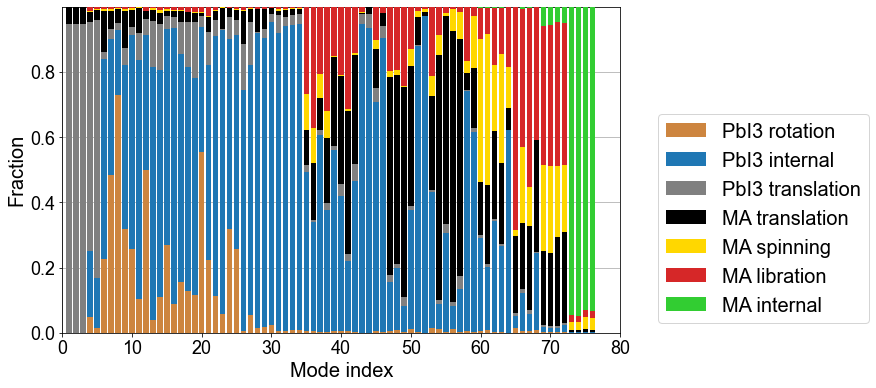

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib as mpl

params = {'backend': 'ps',
          'text.latex.preamble': ['\\usepackage{gensymb}'],
          'axes.labelsize': 22, # fontsize for x and y labels (was 10)
          'axes.titlesize': 10,
          'font.size': 11, # was 10
          'legend.fontsize': 6, # was 10
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': False,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial'
}

mpl.rcParams.update(params)

fig = plt.figure(figsize=(10,6))

nrows = 1
ncols = 1

gs = gridspec.GridSpec(nrows=nrows, ncols=ncols)
gs.update(hspace=0.3)

evals = np.loadtxt('omegas_kayser.dat')



fractions_arr = np.array(fractions_all)
ax = plt.subplot(gs[0])

ax.bar(range(1,77), fractions_arr[:76,5] + fractions_arr[:76,6], label="PbI3 rotation", zorder=3, 
       alpha=1, color='peru')
ax.bar(range(1,77), fractions_arr[:76,7], bottom = fractions_arr[:76,5] + fractions_arr[:76,6], label="PbI3 internal", 
       zorder=3, alpha=1, color='C0')
ax.bar(range(1,77), fractions_arr[:76,4], label="PbI3 translation", 
       bottom=np.sum(fractions_arr[:76,5:8],axis=1), zorder=3, alpha=1, color='gray')

ax.bar(range(1,77), fractions_arr[:76,0], bottom= np.sum(fractions_arr[:76,4:8],axis=1), 
       label="MA translation", zorder=3,  alpha=1, color='black')
ax.bar(range(1,77), fractions_arr[:76,1], bottom = np.sum(fractions_arr[:76,4:8],axis=1) + fractions_arr[:76,0],
       label="MA spinning", zorder=3, alpha=1, color='gold')
ax.bar(range(1,77), fractions_arr[:76,2], bottom = np.sum(fractions_arr[:76,4:8],axis=1) + np.sum(fractions_arr[:76,0:2],axis=1),
       label="MA libration", zorder=3, alpha=1, color='C3')
ax.bar(range(1,77), fractions_arr[:76,3], 
       bottom = np.sum(fractions_arr[:76,4:8],axis=1) + np.sum(fractions_arr[:76,0:3],axis=1),
       label="MA internal", zorder=3, alpha=1, color='limegreen')

ax.set_xlim(0,80)

ax.grid()
ax.set_ylabel('Fraction', fontsize=20)
ax.set_xlabel("Mode index", fontsize=20)

plt.legend(loc='best',bbox_to_anchor=(1.05, 0.7), fontsize=20)

plt.savefig('Fraction_vibrational_types_MAPI.pdf', bbox_inches='tight')


plt.show()



